# Fantasy Football Points Projection

In [2]:
%load_ext watermark

In [13]:
%watermark -a 'Duckman' -u -d -v -p numpy,pandas,matplotlib,seaborn

Author: Duckman

Last updated: 2023-01-18

Python implementation: CPython
Python version       : 3.9.12
IPython version      : 8.7.0

numpy     : 1.21.5
pandas    : 1.4.4
matplotlib: 3.5.1
seaborn   : 0.12.1



In [4]:
pip install nfl_data_py

Note: you may need to restart the kernel to use updated packages.


In [5]:
import nfl_data_py as nfl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Where Expected Points came from
Expected points is a statistical concept used in the NFL to quantify the value of different game situations. The concept was first introduced by Virgil Carter and Robert Machol in the 1970s. Where they showed (what most people naturally assume) that possessing the ball closer to the opponent's endzone will result in a higher chance of scoring. They demonstrated this mathematically by looking at historical data of where drives started from and what they resulted in. Using this information they developed a model to show how probability of scoring increases as the possession team approaches an opponent's enzone.

In [6]:
years = [2022]
df = nfl.import_pbp_data(years)
df = df[['posteam','ep','epa','qb_dropback','down','yardline_100','td_prob','fg_prob','ydstogo']]
df.dropna(inplace=True)
df.drop(index = df[(df['td_prob'] == 0)&(df['fg_prob'] == 0)].index,inplace=True)

2022 done.
Downcasting floats.


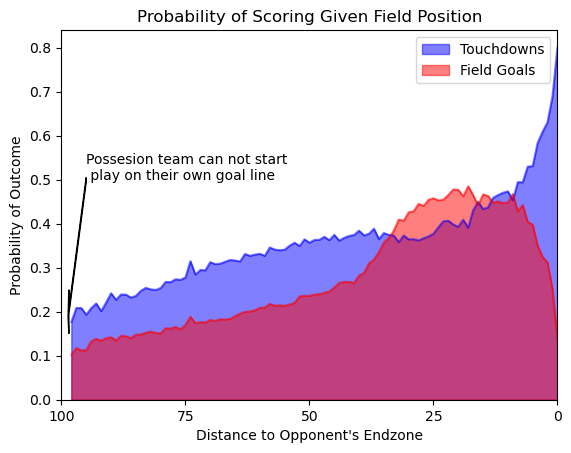

In [8]:
test = df.groupby('yardline_100')[['td_prob','fg_prob']].mean().reset_index()
g = test.plot(y=['td_prob','fg_prob'], kind='area', stacked = False, colormap = 'bwr')
g.set_xlim(99,0)
g.set_xticks([100,75,50,25,0], minor=False)
g.set_title('Probability of Scoring Given Field Position')
g.set_ylabel('Probability of Outcome')
g.set_xlabel("Distance to Opponent's Endzone")
new_labels = ['Touchdowns','Field Goals']
g.annotate("Possesion team can not start\n play on their own goal line", (95, 0.5))
g.arrow(x=95, y=0.5, dx = 3.5,dy = -0.3, width = .01, head_width = .1)
for t,l in zip(g.legend_.texts, new_labels):
    t.set_text(l)   
plt.show()

## What are Expected Points
Expected points are used to determine the average number of points that a team is expected to score on a possession, based on their current field position. It is calculated by taking into account the probability of different outcomes, such as touchdowns, field goals, and punts, and multiplying that probability by the point value of that outcome. 
- **Example**
    - If a team is at the 50 yard line and the probability of a touchdown on that drive is 36%, the expected points from touchdowns would be 2.52 (0.36 * 7). The total expected points for a possession is determined by adding together the expected points for all potential outcomes. This information can be useful for coaches and analysts to make strategic decisions during the game and evaluate the performance of a team over time.

## Moving Expected Points into the Future

The modern Expected Points models have undergone significant developments, taking into account a wider range of game-related factors. Today's models do not simply rely on field position, they also include other elements such as the current down and distance, the amount of time left in the half, and the expected points the opposing team would gain if the ball is kicked or lost. This allows for a deeper level of analysis, including the determination of the specific value of downs in certain areas of the field.

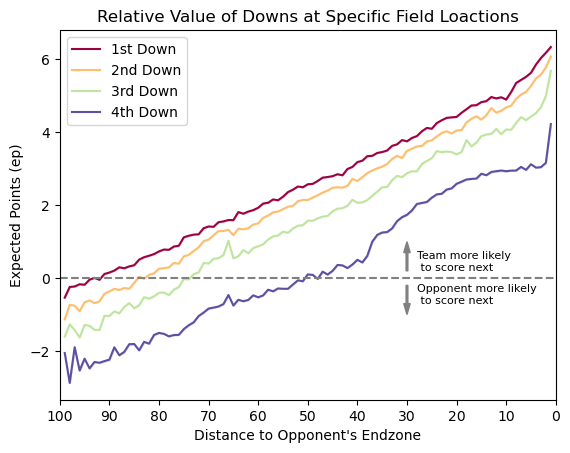

In [11]:
g = sns.lineplot(df,x='yardline_100',y='ep',hue='down',errorbar=('ci',False), palette = 'Spectral')
g.set_xlim((100,0))
g.set_xticks(range(0,110, 10))
g.set_ylabel('Expected Points (ep)')
g.set_xlabel("Distance to Opponent's Endzone")
g.axhline(0, c='gray', linestyle = "--")
g.annotate('Team more likely \n to score next',xy=(28,.2),fontsize =8)
g.arrow(30,.2,0,.5,length_includes_head=False, width = .35, head_width = 1.3,head_length= .3, color='gray')
g.arrow(30,-.2,0,-.5,length_includes_head=False, width = .35, head_width = 1.3,head_length= .3, color='gray')
g.annotate('Opponent more likely \n to score next',xy=(28,-.7),fontsize =8)
new_labels = ['1st Down','2nd Down','3rd Down', '4th Down']
new_title = 'Down'
for t, l in zip(g.legend_.texts, new_labels):
    t.set_text(l)
g.legend_.set_title(None)
g.set(title = 'Relative Value of Downs at Specific Field Loactions')
plt.show()

## Expected Points to "Stay on Schedule"

When a team starts with 1st and 10 from their own 8 yard line, it's more likely that their opponent will score next, resulting in negative Expected Points. However, when a team starts with 1st and 10 from their own 30 yard line, they have the same expected points as when they have 3rd and 10 from midfield. This means that having 1st and 10 from the 30 yard line is equivalent to having 3rd and 10 from the 50 yard line. By including the distance-to-go, we can gain a better understanding of the number of yards that need to be gained to "stay on schedule" and reach the next first down.

For most positions on the field, 1st and 10 is equivalent to 2nd and 2, so in order to retain the predicted number of points on a drive (also known as "staying on schedule"), a team must gain 8 yards every play. 

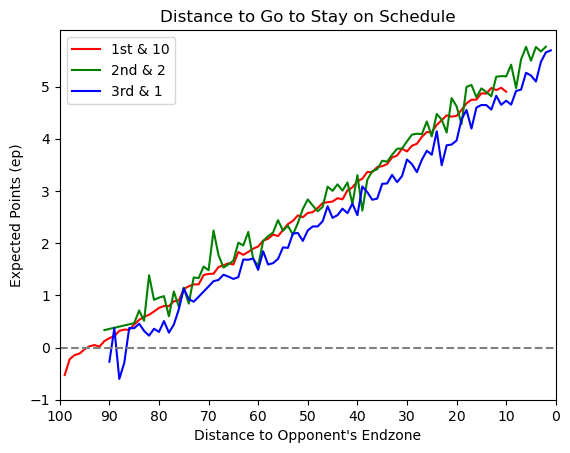

In [12]:
ydsdown = df.groupby(['yardline_100','down','ydstogo'], as_index = False)['ep'].mean()
first_ten = ydsdown.loc[(ydsdown['ydstogo']==10)&(ydsdown['down']==1)]
second_two = ydsdown.loc[(ydsdown['ydstogo']==2)&(ydsdown['down']==2)]
third_one = ydsdown.loc[(ydsdown['ydstogo']==1)&(ydsdown['down']==3)]
stayonschedule = pd.concat([first_ten,second_two,third_one])
g = sns.lineplot(stayonschedule,x='yardline_100',y='ep', hue = 'down',palette = ['r','g','b'])
g.set_xticks(range(0,110, 10))
g.set(title = 'Distance to Go to Stay on Schedule')
g.axhline(0, c='gray', linestyle = "--")
g.set_xlim((100,0))
g.set_yticks(np.arange(-1,6,1))
new_labels = ['1st & 10','2nd & 2','3rd & 1']
new_title = 'Stay on Schedule'
for t, l in zip(g.legend_.texts, new_labels):
    t.set_text(l)
g.legend_.set_title(None)
g.set_ylabel('Expected Points (ep)')
g.set_xlabel("Distance to Opponent's Endzone")
plt.show()